In [1]:
import numpy as np
import matplotlib.pyplot as plt
import PSO_species.pso as pso
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from matplotlib.cm import ScalarMappable
from matplotlib.animation import FuncAnimation, PillowWriter

In [9]:
# Experiment Parameters:

dimension = 3
number_of_particles = 100
bounds = [[-100,100] for _ in range(dimension)]
use_adaptive_hyper_parameters = True
use_adaptive_boxes = True
use_species = True
species_weights = [0.4, 0.3, 0.2, 0.1]
maximise = False

def GenerateY (X):
    result = 0
    for x in X: 
        result += x**2
    return result

pso = pso.Pso(dimension, number_of_particles, bounds, use_adaptive_hyper_parameters, use_adaptive_boxes, use_species, species_weights, GenerateY, maximise)

In [10]:
def griewank(X):
    try:
        Y = []
        for x in X:
            total1 = 0
            total2 = 1
            for i in range(len(x)):
                total1 += x[i]**2
                total2 *= np.cos(x[i] / np.sqrt(i+1))
            y = total1 / 4000 - total2 + 1
            Y.append(y)
        return Y
    except:
        total1 = 0
        total2 = 1
        for i in range(len(X)):
            total1 += X[i]**2
            total2 *= np.cos(X[i] / np.sqrt(i+1))
        return total1 / 4000 - total2 + 1

pso.GenerateY = griewank 

In [2]:
# Setup the box width function
def BoxWidthFunction(iteration):
    if iteration < 10:
        return 2
    else:
         return 0.0001

pso.BoxWidthFunction = BoxWidthFunction

In [3]:
def SampleSizeFunction(iteration):
    return 10
pso.SampleSizeFunction = SampleSizeFunction

In [4]:
pso.mesh_coarseness = 25
pso.mesh_bound_reduction_factor = 0.75

In [14]:
griewank([0, 0, 0])

np.float64(0.0)

/home/vol01/scarf1371/anaconda3/envs/Bayesian/lib/python3.11/site-packages/scipy/stats/_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


IndexError: list index out of range

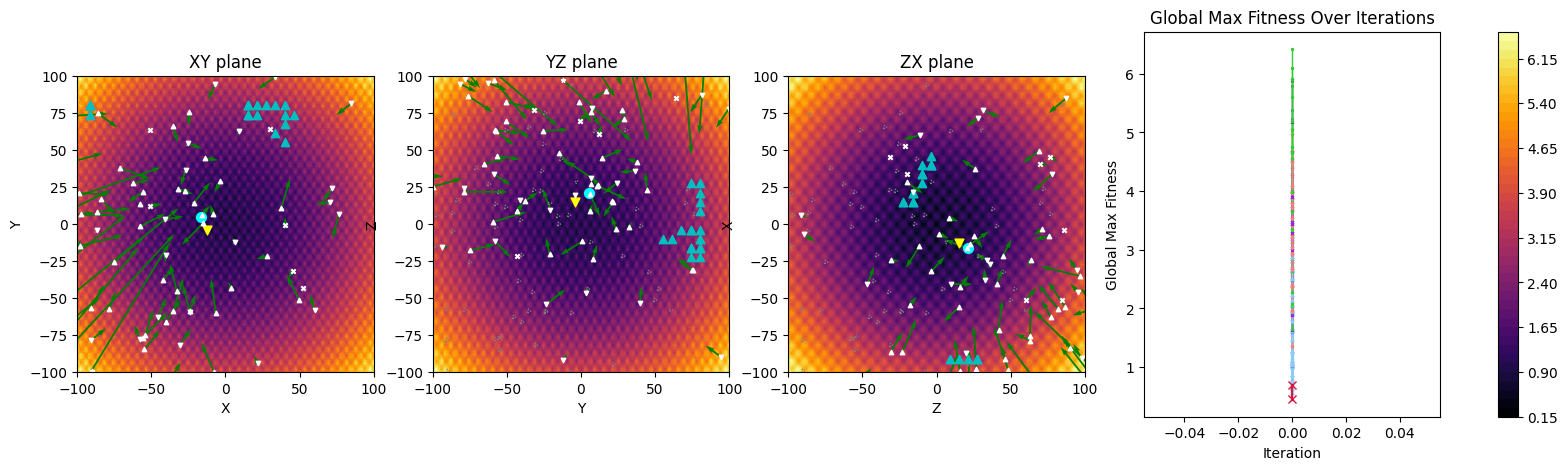

In [15]:
# Define your functions and variables
def compute_plane(X, Y, func, fixed_var, fixed_value):
    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            if fixed_var == 'z':
                Z[i, j] = func([X[i, j], Y[i, j], fixed_value])
            elif fixed_var == 'x':
                Z[i, j] = func([fixed_value, X[i, j], Y[i, j]])
            elif fixed_var == 'y':
                Z[i, j] = func([X[i, j], fixed_value, Y[i, j]])
    return Z

def plot_plane(ax, X, Y, VX, VY, bounds_2d, plane_name, Z, X_mesh, Y_mesh):
    c = ax.contourf(X_mesh, Y_mesh, Z, levels=50, cmap='inferno')
    ax.quiver(X, Y, VX, VY, angles='xy', scale_units='xy', scale=2, color='green')
    # ax.scatter(X, Y, color='white', s=30, marker='*')
    for i in range(len(X)):
        x_min, x_max = bounds_2d[i][0]
        y_min, y_max = bounds_2d[i][1]
        ax.add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, fill=False, edgecolor='gray', linestyle='dotted'))
    ax.set_title(f"{plane_name} plane")
    ax.set_xlabel(plane_name[0])
    ax.set_ylabel(plane_name[1])
    ax.set_aspect('equal', adjustable='box')  # Ensure the aspect ratio is equal

# Generate the grid for the heat maps
x_range = np.linspace(-100, 100, 100)
y_range = np.linspace(-100, 100, 100)
X, Y = np.meshgrid(x_range, y_range)

# Calculate Z values for each plane
Z_xy = compute_plane(X, Y, griewank, 'z', 1)  # z = 1
Z_xz = compute_plane(X, Y, griewank, 'y', 1)  # y = 1
Z_yz = compute_plane(X, Y, griewank, 'x', 1)  # x = 1

# Create the figure and axis objects
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.subplots_adjust(right=0.85)  # Adjust the layout manually

# Initial plots for color bar
c = axes[0].contourf(X, Y, Z_xy, levels=50, cmap='inferno')
cb = fig.colorbar(c, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)

gmax = []
local_maxima = []
iterations = []

# Function to update the plots for each frame
def update(frame):
    # Run one iteration of PSO
    pso.Iterate(1)

    if local_maxima == []:
        for particle in pso.swarm.particles:
            local_maxima.append([particle.local_max])
    else:
        for p, particle in enumerate(pso.swarm.particles):
            local_maxima[p].append(particle.local_max)

    gmax.append(pso.swarm.global_max)
    iterations.append(frame)
    
    # Update data for all particles
    X0 = [pso.swarm.particles[p].position[0] for p in range(pso.number_of_particles)]
    X1 = [pso.swarm.particles[p].position[1] for p in range(pso.number_of_particles)]
    X2 = [pso.swarm.particles[p].position[2] for p in range(pso.number_of_particles)]
    V0 = [pso.swarm.particles[p].velocity[0] for p in range(pso.number_of_particles)]
    V1 = [pso.swarm.particles[p].velocity[1] for p in range(pso.number_of_particles)]
    V2 = [pso.swarm.particles[p].velocity[2] for p in range(pso.number_of_particles)]
    species = [pso.swarm.particles[p].species for p in range(pso.number_of_particles)]
    species_markers = {0: '^', 1: 'v', 2: '*', 3: 'x'}
    species_colors = {0: 'lightskyblue', 1: 'lightcoral', 2: 'limegreen', 3: 'blueviolet'}
    markers = [species_markers[s] for s in species ]

    box_bounds = [pso.swarm.particles[p].box.bounds for p in range(pso.number_of_particles)]
    
    adventure_leads = pso.swarm.adventure_leads
    ad_leads_x = [adventure_leads[p][0] for p in range(len(adventure_leads))]
    ad_leads_y = [adventure_leads[p][1] for p in range(len(adventure_leads))]
    ad_leads_z = [adventure_leads[p][2] for p in range(len(adventure_leads))]
    
    # Clear previous plots in each subplot (but keep color bar)
    for ax in axes:
        ax.clear()

    # Redraw heatmap and particles on each plane
    plot_plane(axes[0], X0, X1, V0, V1, box_bounds, "XY", Z_xy, X, Y)
    # axes[0].scatter(X0, X1, color='white', s=20, marker=markers)
    axes[0].scatter(ad_leads_x, ad_leads_y, marker='^', color='c')
    axes[0].scatter(pso.swarm.global_max_loc[0], pso.swarm.global_max_loc[1], color='cyan', s=50)
    axes[0].scatter(pso.swarm.predicted_max_loc[0], pso.swarm.predicted_max_loc[1], color='yellow', marker='v', s=40)
    
    plot_plane(axes[1], X1, X2, V1, V2, box_bounds, "YZ", Z_xz, X, Y)
    # axes[1].scatter(X1, X2, color='white', s=20, marker=markers)
    axes[1].scatter(ad_leads_y, ad_leads_z, marker='^', color='c')
    axes[1].scatter(pso.swarm.global_max_loc[1], pso.swarm.global_max_loc[2], color='cyan', s=50)
    axes[1].scatter(pso.swarm.predicted_max_loc[1], pso.swarm.predicted_max_loc[2], color='yellow', marker='v', s=40)
    
    plot_plane(axes[2], X2, X0, V2, V0, box_bounds, "ZX", Z_yz, X, Y)
    # axes[2].scatter(X2, X0, color='white', s=20, marker=markers)
    axes[2].scatter(ad_leads_z, ad_leads_x, marker='^', color='c')
    axes[2].scatter(pso.swarm.global_max_loc[2], pso.swarm.global_max_loc[0], color='cyan', s=50)
    axes[2].scatter(pso.swarm.predicted_max_loc[2], pso.swarm.predicted_max_loc[0], color='yellow', marker='v', s=40)

    for particle in pso.swarm.particles:
        axes[0].scatter(particle.position[0], particle.position[1], color='white', s=10, marker=species_markers[particle.species],)
        axes[1].scatter(particle.position[1], particle.position[2], color='white', s=10, marker=species_markers[particle.species])
        axes[2].scatter(particle.position[2], particle.position[0], color='white', s=10, marker=species_markers[particle.species])

    for p, particle in enumerate(pso.swarm.particles):
        axes[3].plot(iterations, local_maxima[p], marker=species_markers[particle.species], color=species_colors[particle.species], linewidth=1, markersize=2)

    axes[3].plot(iterations, gmax, color='crimson', marker='x')
    axes[3].set_title("Global Max Fitness Over Iterations")
    axes[3].set_xlabel("Iteration")
    axes[3].set_ylabel("Global Max Fitness")

    axes[0].set_xlim(-100, 100)
    axes[0].set_ylim(-100, 100)
    axes[1].set_xlim(-100, 100)
    axes[1].set_ylim(-100, 100)
    axes[2].set_xlim(-100, 100)
    axes[2].set_ylim(-100, 100)

        # Add legend to each subplot
    # for ax in axes[:3]:
    #     ax.legend()

# Create the animation
ani = FuncAnimation(fig, update, frames=100, repeat=False)

# Save the animation as a GIF
ani.save('/work4/clf/Josh/Bayesian/PSO_species/pso_animation.gif', writer=PillowWriter(fps=1))

# Show the animation
plt.show()

In [ ]:
print(pso.swarm.global_max)

0.06658407284086776


In [ ]:
for particle in pso.swarm.particles:
    if particle.species == 2:
        print(particle.position)

[ 28.04988438 -51.81152394  43.75005086]
[-46.95011562 -58.06152394  18.75005086]
[ 9.29988438 35.68847606 68.75005086]
[ 34.29988438  73.18847606 -18.74994914]
[ 40.54988438 -39.31152394 -68.74994914]
[-40.70011562  35.68847606 -37.49994914]
[-34.45011562  54.43847606  37.50005086]
[-59.45011562   4.43847606 -62.49994914]
[15.54988438 73.18847606 56.25005086]
[21.79988438 66.93847606 12.50005086]
[-53.20011562 -45.56152394 -56.24994914]
[ 21.79988438 -14.31152394 -43.74994914]
[ -9.45011562  48.18847606 -43.74994914]
[ 28.04988438  54.43847606 -12.49994914]
[ 34.29988438  41.93847606 -62.49994914]
[ 46.79988438  23.18847606 -43.74994914]
[-28.20011562 -39.31152394 -49.99994914]
[ 46.79988438 -70.56152394  25.00005086]
[ 21.79988438  16.93847606 -43.74994914]
[-53.20011562 -45.56152394  56.25005086]
[-59.45011562  -8.06152394  12.50005086]
[46.79988438 35.68847606 56.25005086]
[-71.95011562  60.68847606 -62.49994914]
[-28.20011562 -58.06152394  56.25005086]
[ -9.45011562  29.43847606 -

In [5]:
# Experiment Parameters:

import numpy as np
import matplotlib.pyplot as plt
import PSO_species.pso as pso
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from matplotlib.cm import ScalarMappable
from matplotlib.animation import FuncAnimation, PillowWriter

dimension = 2
number_of_particles = 50
#bounds = [[-100,100] for _ in range(dimension)]
bounds = [[-5, 10], [0, 15]]
use_adaptive_hyper_parameters = True
use_adaptive_boxes = True
use_species = True
species_weights = [0.4, 0.3, 0.2, 0.1]
maximise = False

def GenerateY (X):
    result = 0
    for x in X:
        result += x**2
    return result

pso = pso.Pso(dimension, number_of_particles, bounds, use_adaptive_hyper_parameters, use_adaptive_boxes, use_species, species_weights, GenerateY, maximise)

pso.mesh_coarseness = 25
pso.mesh_bound_reduction_factor = 0.75

In [6]:
def BraninHoo(X):
    Y = []
    for x in X:
        x1 = x[0]
        x2 = x[1]

        # Calculate the Branin-Hoo function value
        y = (x2 - (5.1 / (4 * np.pi ** 2)) * x1 ** 2 + (5 / np.pi) * x1 - 6) ** 2
        y += 10 * (1 - (1 / (8 * np.pi))) * np.cos(x1) + 10

        # Add the constraint
        constraint = (x1 - 2.5) ** 2 + (x2 - 7.5) ** 2 - 50 >= 0
        if constraint:
            y = 200  # Apply penalty for constraint violation

        Y.append(y)

    return Y

pso.GenerateY = BraninHoo 

pso.mesh_coarseness = 25
pso.mesh_bound_reduction_factor = 0.75

def SampleSizeFunction(iteration):
    return 10
    # if iteration < 4:
    #     return 5
    # else:
    #     return 1
pso.SampleSizeFunction = SampleSizeFunction

# Setup the box width function
def BoxWidthFunction(iteration):
    if iteration < 4:
        return 2
    else:
         return 0.0001
pso.BoxWidthFunction = BoxWidthFunction

/home/vol01/scarf1371/anaconda3/envs/Bayesian/lib/python3.11/site-packages/scipy/stats/_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


Im stuck!
Im stuck!
Im stuck!
Im interesting!
Im interesting!
Im interesting!
Im interesting!
Im interesting!
Im interesting!
Im interesting!
Im interesting!
Im interesting!
Im interesting!
Im stuck!
Im interesting!
Im interesting!
Im stuck!
Im interesting!
Im interesting!
Im interesting!
Im interesting!
Im interesting!
Im interesting!
Im interesting!
Im stuck!
Im interesting!
Im interesting!
Im interesting!
Im stuck!
Im interesting!
Im interesting!
Im interesting!
Im stuck!
Im interesting!
Im interesting!
Im interesting!
Im interesting!
Im interesting!
Im interesting!
Im interesting!
Im interesting!
Im interesting!
Im stuck!
Im interesting!
Im interesting!
Im interesting!
Im interesting!
Im interesting!
Im interesting!
Im interesting!
Im interesting!
Im interesting!
Im interesting!
Im interesting!
Im interesting!
Im interesting!
Im interesting!
Im interesting!
Im interesting!
Im interesting!
Im interesting!
Im interesting!
Im interesting!
Im stuck!
Im interesting!
Im interesting!
Im i

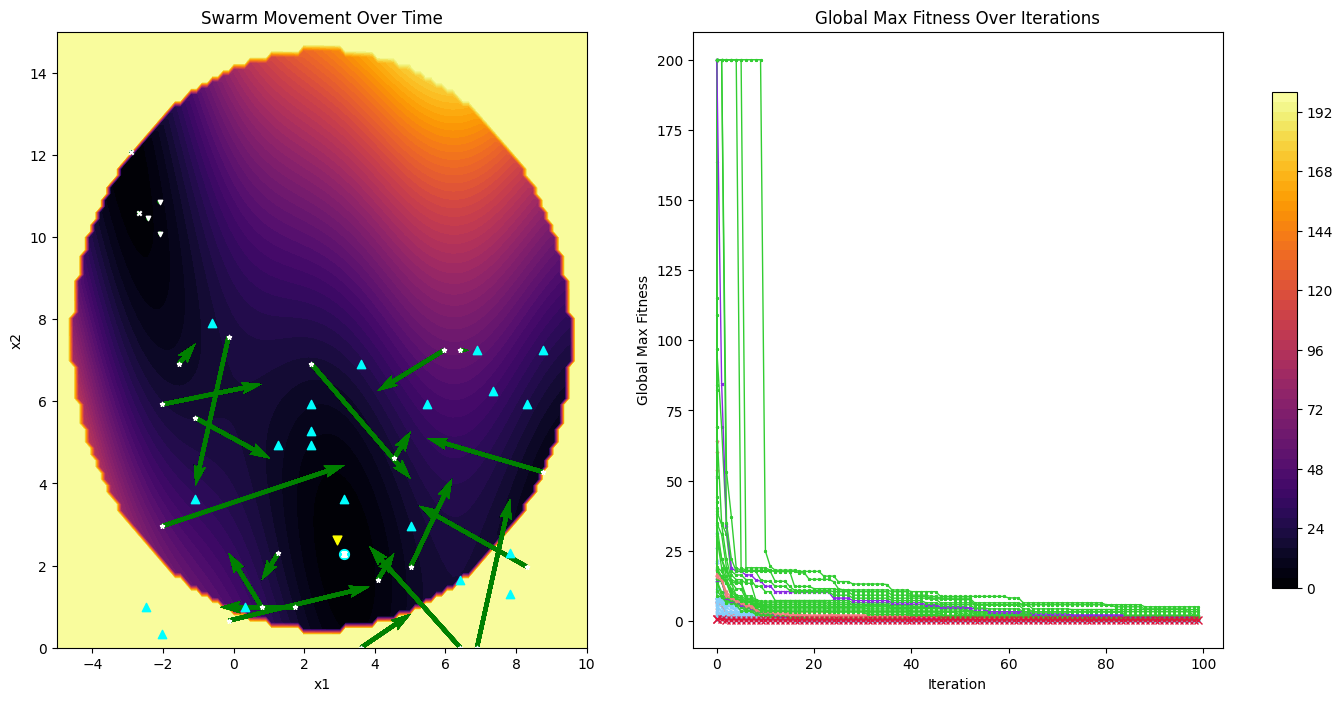

In [7]:
# PSO and animation code remains largely the same

# Generate the grid for the heat maps
x_range = np.linspace(-5, 10, 100)
y_range = np.linspace(0, 15, 100)
X, Y = np.meshgrid(x_range, y_range)

# Calculate Z values for the Branin-Hoo function
Z = np.array(BraninHoo(np.c_[X.ravel(), Y.ravel()])).reshape(X.shape)

# Create the figure and axis objects
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
c = ax[0].contourf(X, Y, Z, levels=50, cmap='inferno')
cb = fig.colorbar(c, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)

# Assuming `pso` object and its methods are defined similarly as before
# Below is a simplified version focusing on 2D particles' visualization

gmax = []
local_maxima = []
iterations = []


# Function to update the plots for each frame
def update(frame):
    # Run one iteration of PSO
    pso.Iterate(1)

    if local_maxima == []:
        for particle in pso.swarm.particles:
            local_maxima.append([particle.local_max])
    else:
        for p, particle in enumerate(pso.swarm.particles):
            local_maxima[p].append(particle.local_max)

    gmax.append(pso.swarm.global_max)
    iterations.append(frame)
    
    # Update data for all particles
    X0 = [pso.swarm.particles[p].position[0] for p in range(pso.number_of_particles)]
    X1 = [pso.swarm.particles[p].position[1] for p in range(pso.number_of_particles)]
    V0 = [pso.swarm.particles[p].velocity[0] for p in range(pso.number_of_particles)]
    V1 = [pso.swarm.particles[p].velocity[1] for p in range(pso.number_of_particles)]
    species = [pso.swarm.particles[p].species for p in range(pso.number_of_particles)]
    species_markers = {0: '^', 1: 'v', 2: '*', 3: 'x'}
    species_colors = {0: 'lightskyblue', 1: 'lightcoral', 2: 'limegreen', 3: 'blueviolet'}
    markers = [species_markers[s] for s in species]

    adventure_leads = pso.swarm.adventure_leads
    ad_leads_x = [adventure_leads[p][0] for p in range(len(adventure_leads))]
    ad_leads_y = [adventure_leads[p][1] for p in range(len(adventure_leads))]
    
    for a in ax:
        a.clear()
    c = ax[0].contourf(X, Y, Z, levels=50, cmap='inferno')
    
    # Plot particles
    for s in species:
        if s != 2:
            ax[0].quiver(X0, X1, V0, V1, angles='xy', scale_units='xy', scale=2, color='green')
    ax[0].scatter(ad_leads_x, ad_leads_y, marker='^', color='cyan')
    ax[0].scatter(pso.swarm.global_max_loc[0], pso.swarm.global_max_loc[1], color='cyan', s=50)
    ax[0].scatter(pso.swarm.predicted_max_loc[0], pso.swarm.predicted_max_loc[1], color='yellow', marker='v', s=40)
    
    for particle in pso.swarm.particles:
        ax[0].scatter(particle.position[0], particle.position[1], color='white', s=10, marker=species_markers[particle.species])
    
    for p, particle in enumerate(pso.swarm.particles):
        ax[1].plot(iterations, local_maxima[p], marker=species_markers[particle.species], color=species_colors[particle.species], linewidth=1, markersize=2)

    ax[1].plot(iterations, gmax, color='crimson', marker='x')
    ax[1].set_title("Global Max Fitness Over Iterations")
    ax[1].set_xlabel("Iteration")
    ax[1].set_ylabel("Global Max Fitness")

    ax[0].set_xlim(-5, 10)
    ax[0].set_ylim(0, 15)
    ax[0].set_title("Swarm Movement Over Time")
    ax[0].set_xlabel("x1")
    ax[0].set_ylabel("x2")

# Create the animation
ani = FuncAnimation(fig, update, frames=100, repeat=False)

# Save the animation as a GIF (optional)
ani.save('/work4/clf/Josh/Bayesian/PSO_species/BraninHoo.gif', writer=PillowWriter(fps=1))

# Show the animation
plt.show()

In [4]:
pso.swarm.global_max

np.float64(0.398611064952913)